## Lotka-Volterra 1 predator 1 prey test

### Roe Deer and Wolf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import *
from random import randint
import scipy
from scipy import signal

# Roe deer and wolf
alpha1 = 9/11 # Birth rate roe deer
beta1 = 0.631*4.86/365.25 # Death rate roe deer
gamma1 =  25/26 # Death rate wolf
delta1 = 0.00356 *0.7*0.5 # Grow rate wolf based on roe deer
epsilon1 = 0.00356 *0.3*0.5 # Grow rate predator based on wild board
eta1 = 4.56 # 6.22 Brith rate wild boar
zeta1 = 5.8*0.6*4.86/365.25# 12.4/365.25 # Death rate wild boar

# Time * step = amount of years
time = 36525 # Approx. amount of days in 100 years
step1 = 1/365.25 # 1 day

# Initial populations
init_pred = 10
init_prey1 = 2500
init_prey12 = 500

# Differential equation predator population
def pred_eq(gamma, delta, epsilon, w, r, z, step):
    return step * w * (-gamma + delta*r + epsilon*z) 

# Differential equation prey1 population
def prey1_eq(alpha, beta, w, r, step):
    return step * r * (alpha - beta*w)

# Differential equation prey2 population
def prey2_eq(eta, zeta, w, z, step):
    return step * z * (eta - zeta*w)

In [2]:
def plot_figure(t, pred, prey1, prey12, title, plot_prey):
    plt.figure(figsize=(12,8))
    plt.plot(t, pred)
    legend_list = ['Wolf']
    
    if plot_prey:
        plt.plot(t, prey1)
        plt.plot(t, prey12)
        legend_list = ['Wolf', 'Roe deer', 'Wild boar']
    
    plt.ylabel('Number of animals')
    plt.xlabel('Time (years)')
    plt.title(title, fontsize=20)
    plt.legend(legend_list, loc='upper left')
    plt.show()

In [3]:
def setup_sliders(init_pred, init_prey1, init_prey12, alpha1, beta1, gamma1, delta1, epsilon1, eta1, zeta1, step1):
    ipred_slider = widgets.IntSlider(value=init_pred, min=0, max=100, step=1)
    iprey1_slider = widgets.IntSlider(value=init_prey1, min=0, max=5000, step=1)
    iprey12_slider = widgets.IntSlider(value=init_prey12, min=0, max=300, step=1)
    a1_slider = widgets.FloatSlider(value=alpha1, min=0, max=3, step=0.1)
    b1_slider = widgets.FloatSlider(value=beta1, min=0, max=3, step=0.1)
    g1_slider = widgets.FloatSlider(value=gamma1, min=0, max=3, step=0.1)
    d1_slider = widgets.FloatSlider(value=delta1, min=0, max=0.2, step=0.01)
    e1_slider = widgets.FloatSlider(value=epsilon1, min=0, max=0.2, step=0.01)
    et1_slider = widgets.FloatSlider(value=eta1, min=0, max=7, step=0.1)
    z1_slider = widgets.FloatSlider(value=zeta1, min=0, max=3, step=0.01)
    s1_slider = widgets.FloatSlider(value=step1, min=0, max=0.005, step=0.0001)
    period_slider = widgets.IntSlider(value=365, min=0, max=1095, step=1)
    pop_coef_slider = widgets.FloatSlider(value=0.9, min=0, max=1, step=0.01)
    scale_slider = widgets.IntSlider(value=1, min=1, max=100, step=1)
    plot_prey_checkbox = widgets.Checkbox(value=True, disabled=False)
    
    return [ipred_slider, iprey1_slider, iprey12_slider, 
            a1_slider, b1_slider, g1_slider, d1_slider, 
            e1_slider, et1_slider, z1_slider, s1_slider, 
            period_slider, pop_coef_slider, scale_slider, plot_prey_checkbox]

In [15]:
def verification(init_pred, init_prey1, init_prey12, step1, per, pop_coef1, 
            shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, title, scale, plot_prey):
    
    update(init_pred, init_prey1, init_prey12, step1, per, pop_coef1, 
            shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, title, scale, plot_prey)

In [ ]:
def lotka_volterra(params, alpha1=alpha1, beta1=beta1, gamma1=gamma1, 
                   delta1=delta1, epsilon1=epsilon1, eta1=eta1, zeta1=zeta1):
    
    # unpack paramters from params
    init_pred, init_prey1, init_prey12, step1, period1, pop_coef1, shoot_deer, shoot_boar, shoot_wolf, introduce_wolf = params
    
    # Initialize arrays for number of animals in populations
    pred = [init_pred]
    prey1 = [init_prey1]
    prey12 = [init_prey12]

    num_pred = init_pred
    num_prey1 = init_prey1
    num_prey12 = init_prey12
    
    period = period1*365.25
    pop_coeff = pop_coef1

    # Update the number of animals time times and store them in arrays
    for n in range(time):
        dpred = pred_eq(gamma1, delta1, epsilon1, num_pred, num_prey1, num_prey12, step1)
        dprey1 = prey1_eq(alpha1, beta1, num_pred, num_prey1, step1)
        dprey12 = prey2_eq(eta1, zeta1, num_pred, num_prey12, step1)
        num_pred += dpred
        num_prey1 += dprey1
        num_prey12 += dprey12
        
        # Following a couple of real life events that can occur. To simulate an event
        # uncomment the event and run this cell again.
        
        # Regulation event 1. Every year prey regulation. 
        
        # Shoot percentage of the deer every period.
        if shoot_deer == "percentage" and (n % period == 0):
            num_prey1 *= pop_coeff
        
        # Shoot a set amount of the deer every period.
        elif shoot_deer == "static" and (n % period == 0):
            if (num_prey1 > pop_coeff):
                num_prey1 -= pop_coeff
            else:
                num_prey1 = 0
                
        # Shoot a percentage of the growth every period.
        elif shoot_deer == "dynamic" and (n % period == 0):
            num_prey1 -= dprey1 * pop_coeff
            
         # Shoot percentage of the boar every period.
        if shoot_boar == "percentage" and (n % period == 0):
            num_prey12 *= pop_coeff
        
        # Shoot a set amount of the boar every period.
        elif shoot_boar == "static" and (n % period == 0):
            if (num_prey12 > pop_coeff):
                num_prey12 -= pop_coeff
            else:
                num_prey12 = 0
                
        # Shoot a percentage of the growth every period.
        elif shoot_boar == "dynamic" and (n % period == 0):
            num_prey12 -= dprey12 * pop_coeff
            
         # Shoot percentage of the wolf every period.
        if shoot_wolf == "percentage" and (n % period == 0):
            num_pred *= pop_coeff
        
        # Shoot a set amount of the wolf every period.
        elif shoot_wolf == "static" and (n % period == 0):
            if (num_pred > pop_coeff):
                num_pred -= pop_coeff
            else:
                num_pred = 0
                
        # Shoot a percentage of the growth every period.
        elif shoot_wolf == "dynamic" and (n % period == 0):
            num_pred -= dpred * pop_coeff
        
        # gradual (monthly) introduction/increase of wolves.
        # Start with 1 wolf and comment 
        if introduce_wolf and (n % period == 0):
            num_pred += pop_coeff * 10
        
        pred.append(num_pred)
        prey1.append(num_prey1)
        prey12.append(num_prey12)
    
    return [pred, prey1, prey12]


def update(init_pred, init_prey1, init_prey12, step1, period1, pop_coef1, 
            shoot_deer, shoot_boar, shoot_wolf, introduce_wolf, title, scale, plot_prey):

    params = [init_pred, init_prey1, init_prey12, step1, period1, 
              pop_coef1, shoot_deer, shoot_boar, shoot_wolf, introduce_wolf]
    
    results = lotka_volterra(params)
    
    pred, prey1, prey12 = results
    
    # Plot the figure
    t = range(int((time + 1) / scale))
    t = [step1* x /
         scale for x in t]
    
    # Correct dimensions of the list to prevent dimension
    # errors during plotting.
    last = int((len(pred) - 1) / scale)
    if last > len(t):
        last -= 1
    elif last < len(t):
        last += 1
        
    plot_figure(t, pred[0:last], prey1[0:last], prey12[0:last], title, plot_prey)
    

slider = setup_sliders(init_pred, init_prey1, init_prey12, 
                       alpha1, beta1, gamma1, delta1, epsilon1, 
                       eta1, zeta1, step1)

interact_manual(update, init_pred=slider[0], init_prey1=slider[1], init_prey12=slider[2], step1=slider[10], 
                period1 = slider[11], pop_coef1 = 0.9, 
                shoot_deer = ["none", "percentage", "static", "dynamic"], 
                shoot_boar = ["none", "percentage", "static", "dynamic"],
                shoot_wolf = ["none", "percentage", "static", "dynamic"],
                introduce_wolf = False, title="Wolf-Roe deer-Wild boar model",
                scale = slider[13], plot_prey = slider[14]);

interactive(children=(IntSlider(value=10, description='init_pred'), IntSlider(value=2500, description='init_pr…

[16, 15, 14, 14, 13, 13, 12, 11, 10, 11, 10] 
 [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]


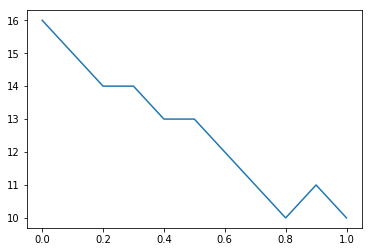

In [ ]:
def get_periodicity(data, height=150, index=0):
    ''' returns the amount of peaks (periods) in data '''
    return len(scipy.signal.find_peaks(data, height=height)[index])

def periodicity(index, p_min, p_max, steps, params):
    results = []
    step_size = (p_max - p_min) / steps
    
    while p_min <= p_max:
        params[5] = p_min
        num_periods = get_periodicity((lotka_volterra(params)[index]))
        results.append(num_periods)
        p_min += step_size
    
    return results

def periodicity_winters(a_min, a_max, e_min, e_max, steps, params):
    a_results = []
    e_results = []
    a_step_size = (a_max - a_min) / steps
    e_step_size = (e_max - e_min) / steps
    
    while a_min <= a_max:
        num_periods = get_periodicity((lotka_volterra(params, alpha1=a_min)[0]))
        a_results.append(num_periods)
        a_min += a_step_size
    
    while e_min <= e_max:
        num_periods = get_periodicity((lotka_volterra(params, eta1=e_min)[0]))
        e_results.append(num_periods)
        e_min += e_step_size
    
    return a_results, e_results


def plot_stats(results, start, end, steps):
    x_range = list(np.arange(start, end+steps, steps))
    print(results, "\n", x_range)
    plt.plot(x_range, results)
    plt.show()
    return

# shoot percentage
params_p = [init_pred, init_prey1, init_prey12, step1, 1, 0.9, 'percentage', 'none', 'none', False]
results = periodicity(0, 0, 1, 10, params_p)
plot_stats(results, 0, 1, 0.1)

# shoot set amount
params_s = [init_pred, init_prey1, init_prey12, step1, 1, 0.9, 'static', 'none', 'none', False]
results = periodicity(0, 0, 1000, 10, params_s)
plot_stats(results, 0, 1000, 100)

# introduce wolves
params_i = [init_pred, init_prey1, init_prey12, step1, 1, 0.9, 'none', 'none', 'none', True]
results = periodicity(0, 0, 1, 10, params_i)
plot_stats(results, 0, 1, 0.1)

# severe winters
params_w = [init_pred, init_prey1, init_prey12, step1, 1, 0.9, 'none', 'none', ' none', False]
a_results, e_results = periodicity_winters(0, 1, 0, 1, 10, params_w)
plot_stats(a_results, 0, 1, 0.1)
plot_stats(e_results, 0, 1, 0.1)

# Model Verification

In [ ]:
# If any initial population is 0 and they are not introduced, it should stay 0 always.
title = "If any initial population is 0 and they are not introduced,\n it should stay 0 always."
scale = 1
plot_prey = True
verification(0, 0, 0, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey)

# If the initial predator population is 0 and the initial prey population are >0, 
# then the prey should grow indefinitely.
title = "If the initial predator population is 0 and the initial prey population are >0,\n then the prey should grow indefinitely (Roe Deer)." 
verification(0, 10, 0, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey)

title = "If the initial predator population is 0 and the initial prey population are >0,\n then the prey should grow indefinitely (Wild Boar)." 
# If the initial predator population is 0 and the initial prey population are >0, 
# then the prey should grow indefinitely.
verification(0, 0, 10, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey)

title = "If the initial prey populations are 0 and the initial predator population is >0,\n the predator population should die out quickly (2 weeks[1])"
# If the initial prey populations are 0 and the initial predator population is >0, 
# the predator population should die out quickly (2 weeks[1])
verification(1000, 0, 0, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey)


# If the initial prey populations are way bigger than the initial predator population,
# the predator population must grow quickly in the beginning.
title = "If the initial prey populations are way bigger than the initial predator population,\n the predator population must grow quickly in the beginning."
scale = 60
plot_prey = False
verification(50, 1000, 1000,  step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey)

# If the initial predator population is way bigger than the initial prey populations, 
# the predator population must decrease quickly in the beginning.
title = "If the initial predator population is way bigger than the initial prey populations,\n the predator population must decrease quickly in the beginning."
scale = 60
plot_prey = False
verification(1000, 10, 10, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey)

# The 2 prey populations do not affect each other. If the initial predator population is 0, 
# the prey populations do not show peak and valleys but are exponentially increasing lines.
title = "The 2 prey populations do not affect each other. If the initial predator population is 0,\n the prey populations do not show peak and valleys but are exponentially increasing lines."
scale = 60
plot_prey = True
verification(0, 10, 10, step1, 365, 0.9, 
            False, False, False, False, title, scale, plot_prey)

# If we introduce prey, in the middle of the simulation, the predator population should increase immediately
title = "If we introduce prey, in the middle of the simulation,\n the predator population should increase immediately"
scale = 1
plot_prey = True
verification(10, 10, 0, step1, 365, 0.9, 
            False, False, True, False, title, scale, plot_prey)

# If we introduce predators, in the middle of the simulation, the growth of the prey population should decrease 
# If part of the predator population is shot each period, the average amount of prey in the simulation should be higher than when no predator is shot at all
# If a certain amount of predators is introduced each period, the average amount of prey in the simulation should be lower than when no predator is introduced at all
# If part of both prey population is shot each year, the average amount of prey and predators should be lower than when no prey are shot at all


### Wild Boar and Wolf

In [ ]:
# Wild boar and wolf
alpha2 = 6.22 # Birth rate prey 
beta2 = 12.4 / 182.75  # Death rate prey
gamma2 = 25/26 # Death rate predator
delta2 = 0.0356 # Grow rate predator

# Time * step = amount of years simulated
time2 = 1000000 
step2 = 0.0001

# Initial populations
init_pred2 = 1
init_prey2 = 500

In [ ]:
def update(init_pred2, init_prey2, alpha2, beta2, gamma2, delta2, step2):
    pred2 = [init_pred2]
    prey2 = [init_prey2]

    num_pred2 = init_pred2
    num_prey2 = init_prey2

    for n in range(time):
        dpred2 = pred_eq(gamma2, delta2, num_pred2, num_prey2, step2)
        dprey2 = prey1_eq(alpha2, beta2, num_pred2, num_prey2, step2)
        num_pred2 += dpred2
        num_prey2 += dprey2
        pred2.append(num_pred2)
        prey2.append(num_prey2)

    t2 = range(time2+1)
    t2 = [step2*x for x in t2]

    plt.figure(figsize=(12,8))
    plt.plot(t2, pred2)
    plt.plot(t2, prey2)
    plt.ylabel('Number of animals')
    plt.xlabel('Time (years)')
    plt.title('Wolf-Wild boar model', fontsize=20)
    plt.legend(['Wolf', 'Wild boar'], loc='upper left')
    plt.show()

ipred2_slider = widgets.IntSlider(value=1, min=0, max=100, step=1)
iprey2_slider = widgets.IntSlider(value=500, min=0, max=300, step=1)
a2_slider = widgets.FloatSlider(value=6.22, min=0, max=1, step=0.01)
b2_slider = widgets.FloatSlider(value=12.4/182.75, min=0, max=1, step=0.01)
g2_slider = widgets.FloatSlider(value=25/26, min=0, max=1, step=0.01)
d2_slider = widgets.FloatSlider(value=0.0356, min=0, max=1, step=0.01)
s2_slider = widgets.FloatSlider(value=0.0001, min=0, max=10, step=0.001)

# interact_manual(update, init_pred2=ipred2_slider, init_prey2=iprey2_slider, alpha2 = a2_slider,
#                 beta2 = b2_slider, gamma2 = g2_slider, delta2 = d2_slider, step2=s2_slider);

### Lotka-Volterra Vector Field (Stable Point Visualization) 

In [ ]:
alpha3 = 9/11 # Birth rate prey 
beta3 = 48.6/365.25 # Death rate prey
gamma3 = 25/26 # Death rate predator
delta3 = 0.0356 # Grow rate predator

max_prey = 50 # Maximum begin population of prey
max_pred = 15 # Maximum begin population of predators

arrow_density = 2 # number of arrows per 1 unit

# Make a sample starting point
sample_pred = 7
sample_prey = 29
sample_length = 400
sample_step = 0.1
arrows = True
arrow_distance = 10

In [ ]:
def update(alpha3, beta3, gamma3, delta3, max_prey, max_pred, arrow_density,
          sample_pred, sample_prey, sample_length, sample_step, arrows, arrow_distance):
    
    X, Y = np.meshgrid(np.arange(0, max_prey, 1/arrow_density), np.arange(0, max_pred, 1/arrow_density))

    stable_pred = alpha3 / beta3 # Stable initial population of predators
    stable_prey = gamma3 / delta3 # Stable initial population of prey
    print('The stable point (besides (0,0)) is at %.2f initial preys and %.2f initial predators.' % (stable_prey, stable_pred))

    # Check stability in formulas
    print('Predator difference (should be 0): %.2f' % pred_eq(gamma3, delta3, stable_pred, stable_prey, 1))
    print('Prey difference (should be 0): %.2f' % prey1_eq(alpha3, beta3, stable_pred, stable_prey, 1))

    U = np.zeros(X.shape)
    V = np.zeros(X.shape)

    for r in range(max_prey * arrow_density):
        for c in range(max_pred * arrow_density):
            U[c][r] = prey1_eq(alpha3, beta3, c/arrow_density, r/arrow_density, 1) 
            V[c][r] = pred_eq(gamma3, delta3, c/arrow_density, r/arrow_density, 1) 
            norm = np.sqrt((U[c][r])**2 + (V[c][r])**2)
            if norm != 0:
                U[c][r] = U[c][r] / norm
                V[c][r] = V[c][r] / norm

    s_prey = [sample_prey]
    s_pred = [sample_pred]
    for t in range(sample_length):
        cur_prey = s_prey[-1]
        cur_pred = s_pred[-1]
        s_prey.append(cur_prey + prey1_eq(alpha3, beta3, cur_pred, cur_prey, sample_step))
        s_pred.append(cur_pred + pred_eq(gamma3, delta3, cur_pred, cur_prey, sample_step))

    plt.figure(figsize=(15,14))
    plt.quiver(X, Y, U, V, scale=90, width=0.0015, color='b') # bigger scale is smaller arrows

    # Draw the sample line
    plt.plot(s_prey, s_pred, 'r-')

    # Draw starting point as a dot
    plt.plot(sample_prey, sample_pred, 'ro')

    # Draw arrows in line 
    if arrows:
        for i in range(9, sample_length, arrow_distance):
            if i+1 < sample_length:
                plt.arrow(s_prey[i], s_pred[i], s_prey[i+1]-s_prey[i], s_pred[i+1]-s_pred[i], color='r', head_width=0.2)

    plt.legend(["Example start point (%d prey, %d predators)" % (sample_prey, sample_pred)])
    plt.ylabel('Predator population')
    plt.xlabel('Prey population')
    plt.title('Vector Field of Lotka-Volterra equation', fontsize=20)
    plt.show()


a3_slider = widgets.FloatSlider(value=9/11, min=0, max=1, step=0.01)
b3_slider = widgets.FloatSlider(value=48.6/365.25, min=0, max=1, step=0.01)
g3_slider = widgets.FloatSlider(value=25/26, min=0, max=1, step=0.01)
d3_slider = widgets.FloatSlider(value=0.0356, min=0, max=1, step=0.01)
maxpred_slider = widgets.IntSlider(value=50, min=0, max=100, step=1)
maxprey_slider = widgets.IntSlider(value=15, min=0, max=300, step=1)

arrowdense_slider = widgets.IntSlider(value=2, min=0, max=10, step=1)

sampred_slider = widgets.IntSlider(value=7, min=0, max=100, step=1)
samprey_slider = widgets.IntSlider(value=29, min=0, max=100, step=1)
samplen_slider = widgets.IntSlider(value=400, min=0, max=1000, step=10)

sampstep_slider = widgets.FloatSlider(value=0.1, min=0, max=10, step=0.001)
arrowdist_slider = widgets.IntSlider(value=10, min=0, max=100, step=1)

# interact_manual(update, alpha3=a3_slider, beta3=b3_slider, gamma3=g3_slider, delta3=d3_slider, 
#                 max_prey=maxprey_slider, max_pred=maxpred_slider, arrow_density=arrowdense_slider,
#                 sample_pred=sampred_slider, sample_prey=samprey_slider, sample_length=samplen_slider, 
#                 sample_step=sampstep_slider, arrows=True, arrow_distance=arrowdist_slider);

In [ ]:
r = np.array([9/11, 6.22, 25/26])
A = np.array([[1, 0, -48.6/365.25], [0, 1, ], []])

### Average amount of animals validating tests
- Average amount of animals of 1 species per period and percentage shot per period
- Average amount of animals of 1 species per period and number of animals shot per period
- Average amount of animals of 1 species per period and introduction of wolves per period
- Average amount of animals of 1 species per period and frequency of severe winters

In [ ]:
def make_scatter_plot(independant, dependant, independant_name, dependant_name):
    plt.figure(figsize=(8,6))
    plt.scatter(independant, dependant, c='b')
    plt.ylabel(dependant_name)
    plt.xlabel(independant_name)
    plt.title('Scatter plot of %s and %s' % (dependant_name, independant_name), fontsize=16)
    plt.show()

In [ ]:
from scipy import integrate

def average_amount_array(data_array, time_array):
    area = integrate.simps(data_array, time_array)    
    
    # The period is 100 years.
    return area/100

In [ ]:
def avg_animals_integrate(index, p_min, p_max, steps, params, t_array, type='per'):
    results = []
    indep_var = np.linspace(p_min, p_max, steps+1)
    
    for v in indep_var:
        if type == 'per':
            params[5] = 1 - (v / 100)
        elif type == 'num':
            params[5] = v
        avg_animals = average_amount_array(lotka_volterra(params)[index], t_array)
        results.append(avg_animals)
    
    return indep_var, results

In [ ]:
# Make time array so integral can be calculated
t = range(int(36526))
t = [step1*x for x in t]

# Make the params for the lotka-volterra funciton.
params_per = [init_pred, init_prey1, init_prey12, step1, 1, 0.9, 'none', 'none', 'none', False]

# Make data points for the different species.
params_per[6] = 'percentage'
per_r, res_r = avg_animals_integrate(1, 0, 60, 30, params_per, t) # Roe deer
params_per[6] = 'none'
params_per[7] = 'percentage'
per_b, res_b = avg_animals_integrate(2, 0, 60, 30, params_per, t) # Wild boar
params_per[7] = 'none'
params_per[8] = 'percentage'
per_w, res_w = avg_animals_integrate(0, 0, 100, 30, params_per, t) # Wolves

# Make scatter plots for the different species.
make_scatter_plot(per_r, res_r, 'Percentage roe deer shot every %s year' % params[4], 
                  'Average amount of roe deer per year')
make_scatter_plot(per_b, res_b, 'Percentage wild boar shot every %s year' % params[4], 
                  'Average amount of wild boar per year')
make_scatter_plot(per_w, res_w, 'Percentage wolves shot every %s year' % params[4], 
                  'Average amount of wolves in per year')

In [ ]:
params_num = [init_pred, init_prey1, init_prey12, step1, 1, 0, 'static', 'none', 'none', False]

# Make data points for the different species.
period_deer = params_num[4]
num_r, num_res_r = avg_animals_integrate(1, 0, 100, 30, params_num, t, type='num') # Roe deer
params_num[6] = 'none'
params_num[7] = 'static'
params_num[4] = 21
period_boar = params_num[4]
num_b, num_res_b = avg_animals_integrate(2, 0, 20, 30, params_num, t, type='num') # Wild boar
params_num[7] = 'none'
params_num[8] = 'static'
params_num[4] = 21.5
num_w, num_res_w = avg_animals_integrate(0, 0, 10, 30, params_num, t, type='num') # Wolves

# Make scatter plots for the different species.
make_scatter_plot(num_r, num_res_r, 'Number of roe deer shot every %s year' % period_deer, 
                  'Average amount of roe deer per year')
make_scatter_plot(num_b, num_res_b, 'Number of wild boar shot every %s year' % period_boar, 
                  'Average amount of wild boar per year')
make_scatter_plot(num_w, num_res_w, 'Number of wolves shot every %s year' % params_num[4], 
                  'Average amount of wolves per year')

In [ ]:
# Average amount of animals and percentage of wolves introduced
params_wolf = [init_pred, init_prey1, init_prey12, step1, 1, 0, 'none', 'none', 'none', True]

# Make data points for the different species.
wolf_num, wolf_res = avg_animals_integrate(0, 0, 40, 50, params_wolf, t, type='num')
wolf_num *= 10

# Make scatter plots for the different species.
make_scatter_plot(wolf_num, wolf_res, 'Number of wolves introduced every %s year' % params_wolf[4], 
                  'Average amount of wolves per year')

In [ ]:
# # Average amount of animals and frequency of severe winters
# def avg_animals_winters(a_min, a_max, e_min, e_max, steps, params, t_array, type='per'):
#     results = []
#     alpha = np.linspace(a_min, a_max, steps+1)
#     eta = np.linspace(e_min, e_max, steps+1)
    
#     for a, e in zip(alpha, eta):
#         avg_roe = average_amount_array(lotka_volterra(params, alpha=a, eta=e)[1], t_array)
#         avg_boar = average_amount_array(lotka_volterra(params, alpha=a, eta=e)[2], t_array)
#         results.append(avg_roe + avg_boar)
    
#     return results